# Residual Attention-56 Model(mixed attention) using CIFAR-100

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, TensorBoard
#from utils.preprocess import CIFAR_preprocess, add_noise
from utils.AttentionResNet_CIFAR100 import AttentionResNet56
from utils.residual_unit_CIFAR import residual_unit
from utils.attention_block import attention_stage_1, attention_stage_2, attention_stage_3
%load_ext autoreload
%autoreload 2

## Load CIFAR-100 Data

In [2]:
## dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

train_num = int(len(x_train) * 0.8)
x_val = x_train[train_num:, :, :, :]
y_val = y_train[train_num:]
y_val = y_val.reshape(-1)
x_train = x_train[:train_num, :, :, :]
y_train = y_train[:train_num]
y_train = y_train.reshape(-1)

y_test = y_test.reshape(-1)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_validation shape:', x_val.shape)
print('y_validation shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000,)
x_validation shape: (10000, 32, 32, 3)
y_validation shape: (10000,)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000,)


In [3]:
# calculate mean for each channel
mean = np.array(np.mean(x_train, axis=(0, 1, 2))).reshape([1,1,1,3])
x_train = x_train-mean
x_val = x_val - mean
x_test = x_test - mean

## Data Augmentation

In [4]:
## expand the original image to 40x40, and use random crop 32x32

def processing(image):
    pic = np.zeros(shape = (40, 40, 3))
    for c in range(image.shape[2]):
        a = image[:, :, c]
        a = np.pad(a, (4, 4))
        pic[:, :, c] = a
    pic = tf.image.random_crop(pic, [32, 32, 3], seed = 0)
    return pic

In [5]:
train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            preprocessing_function=processing,
            validation_split=0.2)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_datagen.fit(x_train)
val_datagen.fit(x_val)
test_datagen.fit(x_test)

batch_size = 64
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

## Build up Residual Attention-56 Network

In [6]:
img_input = Input(shape=(32, 32, 3))
output = AttentionResNet56(img_input)
model = Model(img_input, output)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Train the Model

In [8]:
## build a learning rate call back

def lr_schedule(epoch):
    lr = 0.1
    if epoch > 100:
        lr *= 1e-1
    elif epoch > 150:
        lr *= 1e-2
        
    print('Learning rate:', lr)
    return lr
lr_callback = LearningRateScheduler(lr_schedule)

## build an early stopping call back
early_stopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

In [9]:
## use nesterov SGD as mentioned in the paper
model.compile(optimizer = tf.keras.optimizers.SGD(lr_schedule(0), momentum=0.9, nesterov=True, name='SGD', decay = 0.0001),
             loss='sparse_categorical_crossentropy',
             metrics = 'accuracy')

Learning rate: 0.1


In [10]:
start = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs = 180, callbacks=[lr_callback, early_stopper]) # 256
end = time.time()
print("Time taken by above cell is {} min.".format((end-start)/60))

Learning rate: 0.1
Epoch 1/180
625/625 [==============================] - 135s 216ms/step - loss: 4.0042 - accuracy: 0.0794 - val_loss: 4.5879 - val_accuracy: 0.0840 - lr: 0.1000
Learning rate: 0.1
Epoch 2/180
625/625 [==============================] - 131s 210ms/step - loss: 3.5081 - accuracy: 0.1544 - val_loss: 3.4184 - val_accuracy: 0.1874 - lr: 0.1000
Learning rate: 0.1
Epoch 3/180
625/625 [==============================] - 132s 211ms/step - loss: 3.1627 - accuracy: 0.2156 - val_loss: 3.2890 - val_accuracy: 0.2146 - lr: 0.1000
Learning rate: 0.1
Epoch 4/180
625/625 [==============================] - 131s 210ms/step - loss: 2.9068 - accuracy: 0.2658 - val_loss: 3.1423 - val_accuracy: 0.2410 - lr: 0.1000
Learning rate: 0.1
Epoch 5/180
625/625 [==============================] - 131s 210ms/step - loss: 2.7319 - accuracy: 0.3010 - val_loss: 2.8501 - val_accuracy: 0.2907 - lr: 0.1000
Learning rate: 0.1
Epoch 6/180
625/625 [==============================] - 131s 210ms/step - loss: 2.6028 

#### Plot

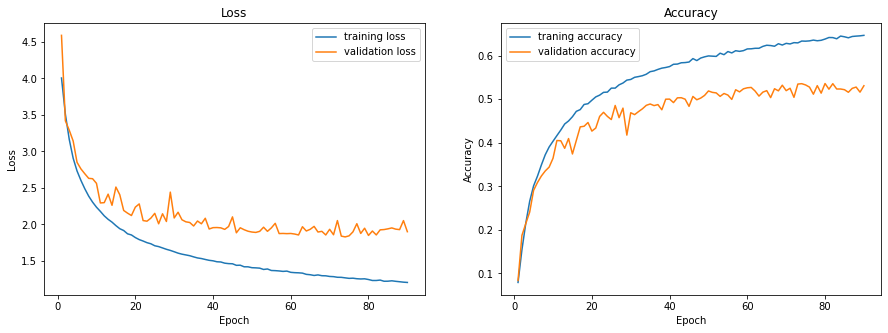

In [12]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 90+1), history.history['loss'], label = 'training loss')
plt.plot(range(1, 90+1), history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, 90+1), history.history['accuracy'], label = 'traning accuracy')
plt.plot(range(1, 90+1), history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [13]:
# evaluation
val_scores = model.evaluate(val_generator, verbose=0)
test_scores = model.evaluate(test_generator, verbose=1)
print('validation loss:', val_scores[0])
print('validation accuracy:', val_scores[1])
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

157/157 [==============================] - 3s 19ms/step - loss: 1.8933 - accuracy: 0.5298
validation loss: 1.9007320404052734
validation accuracy: 0.5307999849319458
Test loss: 1.893290638923645
Test accuracy: 0.5297999978065491


## Save the Model

In [41]:
## save the best model in a dictionary
#save_dir = "./save_models/"
#if not os.path.exists(save_dir):
#    os.makedirs(save_dir)

## Save your model
#save_params = model.save_model()
#with open("./save_models/best_model.pkl", "wb") as output_file:
#    pickle.dump(save_params, output_file)

#model.save('ResidualAttention56_CIFAR10_model.h5')

#history.model.save('./MODEL')

In [14]:
## sava the weights
model.save_weights('ResidualAttention56_CIFAR100_weights.h5')